<a href="https://colab.research.google.com/github/krikorantranik/Work/blob/main/QuickNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example, I use NLP (Doc2Vec) and clustering algorithms to try to classify news by topics.

There are many ways to do this type of classification, such as using supervised methods (a tagged dataset), using clustering and using a specific LDA algorithm (topic modeling).

In [ ]:
import numpy as np
import pandas as pd
import json
pd.options.mode.chained_assignment = None  # default='warn'
from io import StringIO
from html.parser import HTMLParser
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltkstop = stopwords.words('english')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
snow = SnowballStemmer(language='english')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


I generate a dictionary with words with no or generic meaning from different sources that might affect the generation of a correct embedding

In [ ]:
maindataset = pd.read_csv("articles1.csv")
maindataset2 = pd.read_csv("articles2.csv")
maindataset = pd.concat([maindataset,maindataset2], ignore_index=True)

countries = pd.read_json("countries.json")
countries["country"] = countries["country"].str.lower()
countries = pd.DataFrame(countries["country"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
countries.columns = ['word']
countries["replacement"] = "xcountryx"

provincies = pd.read_csv("countries_provincies.csv")
provincies1 = provincies[["name"]]
provincies1["name"] = provincies1["name"].str.lower()
provincies1 = pd.DataFrame(provincies1["name"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies1.columns = ['word']
provincies1["replacement"] = "xprovincex"
provincies2 = provincies[["name_alt"]]
provincies2["name_alt"] = provincies2["name_alt"].str.lower()
provincies2 = pd.DataFrame(provincies2["name_alt"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies2.columns = ['word']
provincies2["replacement"] = "xprovincex"
provincies3 = provincies[["type_en"]]
provincies3["type_en"] = provincies3["type_en"].str.lower()
provincies3 = pd.DataFrame(provincies3["type_en"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies3.columns = ['word']
provincies3["replacement"] = "xsubdivisionx"
provincies4 = provincies[["admin"]]
provincies4["admin"] = provincies4["admin"].str.lower()
provincies4 = pd.DataFrame(provincies4["admin"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies4.columns = ['word']
provincies4["replacement"] = "xcountryx"
provincies5 = provincies[["geonunit"]]
provincies5["geonunit"] = provincies5["geonunit"].str.lower()
provincies5 = pd.DataFrame(provincies5["geonunit"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies5.columns = ['word']
provincies5["replacement"] = "xcountryx"
provincies6 = provincies[["gn_name"]]
provincies6["gn_name"] = provincies6["gn_name"].str.lower()
provincies6 = pd.DataFrame(provincies6["gn_name"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies6.columns = ['word']
provincies6["replacement"] = "xcountryx"
provincies = pd.concat([provincies1,provincies2,provincies3,provincies4,provincies5,provincies6], axis=0, ignore_index=True)

currencies = pd.read_json("country-by-currency-name.json")
currencies1 = currencies[["country"]]
currencies1["country"] = currencies1["country"].str.lower()
currencies1 = pd.DataFrame(currencies1["country"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
currencies1.columns = ['word']
currencies1["replacement"] = "xcountryx"
currencies2 = currencies[["currency_name"]]
currencies2["currency_name"] = currencies2["currency_name"].str.lower()
currencies2 = pd.DataFrame(currencies2["currency_name"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
currencies2.columns = ['word']
currencies2["replacement"] = "xcurrencyx"
currencies = pd.concat([currencies1,currencies2], axis=0, ignore_index=True)

firstnames = pd.read_csv("interall.csv", header=None)
firstnames = firstnames[firstnames[1]>=10000]
firstnames = firstnames[[0]]
firstnames[0] = firstnames[0].str.lower()
firstnames = pd.DataFrame(firstnames[0].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
firstnames.columns = ['word']
firstnames["replacement"] = "xfirstnamex"

lastnames = pd.read_csv("intersurnames.csv", header=None)
lastnames = lastnames[lastnames[1]>=10000]
lastnames = lastnames[[0]]
lastnames[0] = lastnames[0].str.lower()
lastnames = pd.DataFrame(lastnames[0].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
lastnames.columns = ['word']
lastnames["replacement"] = "xlastnamex"

temporaldata = pd.read_csv("temporal.csv")

dictionary = pd.concat([lastnames,temporaldata,firstnames,currencies,provincies,countries], axis=0, ignore_index=True)
dictionary = dictionary.groupby(["word"]).first().reset_index(drop=False)
dictionary = dictionary.dropna()

maindataset

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...,...,...,...,...,...,...,...,...
99994,103453,151902,"If Baltimore is serious about police reform, g...",Guardian,Lawrence Grandpre,2016-08-12,2016.0,8.0,https://www.theguardian.com/commentisfree/2016...,There have been many proposed solutions to the...
99995,103454,151903,The transition from summer to fall feels like ...,Guardian,Mary Valle,2016-08-28,2016.0,8.0,https://www.theguardian.com/commentisfree/2016...,"Maybe I feel like August won’t let go of me, b..."
99996,103455,151904,"Colombia: Farc’s female fighters, then and now...",Guardian,NaN,2016-09-16,2016.0,9.0,https://www.theguardian.com/artanddesign/2016/...,"Diana Marcela, 28, has spent 13 years with Far..."
99997,103456,151905,Why I’m optimistic about 2017,Guardian,Paul Mason,2016-12-26,2016.0,12.0,https://www.theguardian.com/politics/commentis...,"This Christmas break, for anybody steeped in t..."


Function to:

1) Strip HTML tags
2) Replace words using the dictionay crafted above
3) Remove punctuation, double spaces, etc.

In [ ]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def replace_words(tt, lookp_dict):
 temp = tt.split()
 res = []
 for wrd in temp:
  res.append(lookp_dict.get(wrd, wrd))
 res = ' '.join(res)
 return res

def preprepare(eingang):
 ausgang = strip_tags(eingang)
 ausgang = eingang.lower()
 ausgang = ausgang.replace(u'\xa0', u' ')
 ausgang = re.sub(r'^\s*$',' ',str(ausgang))
 ausgang = ausgang.replace('|', ' ')
 ausgang = ausgang.replace('ï', ' ')
 ausgang = ausgang.replace('»', ' ')
 ausgang = ausgang.replace('¿', '. ')
 ausgang = ausgang.replace('ï»¿', ' ')
 ausgang = ausgang.replace('"', ' ')
 ausgang = ausgang.replace("'", " ")
 ausgang = ausgang.replace('?', ' ')
 ausgang = ausgang.replace('!', ' ')
 ausgang = ausgang.replace(',', ' ')
 ausgang = ausgang.replace(';', ' ')
 ausgang = ausgang.replace('.', ' ')
 ausgang = ausgang.replace("(", " ")
 ausgang = ausgang.replace(")", " ")
 ausgang = ausgang.replace("{", " ")
 ausgang = ausgang.replace("}", " ")
 ausgang = ausgang.replace("[", " ")
 ausgang = ausgang.replace("]", " ")
 ausgang = ausgang.replace("~", " ")
 ausgang = ausgang.replace("@", " ")
 ausgang = ausgang.replace("#", " ")
 ausgang = ausgang.replace("$", " ")
 ausgang = ausgang.replace("%", " ")
 ausgang = ausgang.replace("^", " ")
 ausgang = ausgang.replace("&", " ")
 ausgang = ausgang.replace("*", " ")
 ausgang = ausgang.replace("<", " ")
 ausgang = ausgang.replace(">", " ")
 ausgang = ausgang.replace("/", " ")
 ausgang = ausgang.replace("\\", " ")
 ausgang = ausgang.replace("`", " ")
 ausgang = ausgang.replace("+", " ")
 ausgang = ausgang.replace("=", " ")
 ausgang = ausgang.replace("_", " ")
 ausgang = ausgang.replace("-", " ")
 ausgang = ausgang.replace(':', ' ')
 ausgang = ausgang.replace('\n', ' ').replace('\r', ' ')
 ausgang = ausgang.replace(" +", " ")
 ausgang = ausgang.replace(" +", " ")
 ausgang = ausgang.replace('?', ' ')
 ausgang = re.sub('[^a-zA-Z]', ' ', ausgang)
 ausgang = re.sub(' +', ' ', ausgang)
 ausgang = re.sub('\ +', ' ', ausgang)
 ausgang = re.sub(r'\s([?.!"](?:\s|$))', r'\1', ausgang)
 return ausgang


Clean up the dictionary data

In [ ]:
dictionary["word"] = dictionary["word"].apply(lambda x: preprepare(x))
dictionary = dictionary[dictionary["word"] != " "]
dictionary = dictionary[dictionary["word"] != ""]
dictionary = {row['word']: row['replacement'] for index, row in dictionary.iterrows()}

Preparation of the text data to convert: created a new column with a contatenation of the title (4 times) and the summary. This is what will be converted to vectors. Then I replace the stopwords and words in the dictionary

In [ ]:
maindataset["NLPtext"] = maindataset["title"] + maindataset["title"] + maindataset["content"] + maindataset["title"] + maindataset["title"]
maindataset["NLPtext"] = maindataset["NLPtext"].str.lower()
maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: preprepare(str(x)))
maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: ' '.join([word for word in x.split() if word not in (nltkstop)]))
maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: replace_words(str(x), dictionary))

The last part in preparing the text is stemming. This is done in this case, since anyways I am training the model from scratch. The decision to stem or not will depend on the model used, when using pretrained models as in BERT this is not recommended, since the words won't match the words in their libraries.

In [ ]:
def steming(sentence):
 words = word_tokenize(sentence)
 singles = [snow.stem(plural) for plural in words]
 oup = ' '.join(singles)
 return oup

maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: steming(x))
maindataset['lentitle'] = maindataset["title"].apply(lambda x: len(str(x).split(' ')))
maindataset['lendesc'] = maindataset["content"].apply(lambda x: len(str(x).split(' ')))
maindataset['lentext'] = maindataset["NLPtext"].apply(lambda x: len(str(x).split(' ')))
maindataset = maindataset[maindataset['NLPtext'].notna()]
maindataset = maindataset[maindataset['lentitle']>=4]
maindataset = maindataset[maindataset['lendesc']>=4]
maindataset = maindataset[maindataset['lentext']>=4]
maindataset = maindataset.reset_index(drop=False)
maindataset

,index,Unnamed: 0,id,title,publication,author,date,year,month,url,content,NLPtext,lentitle,lendesc,lentext
0,0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,xlastnamex republican fret win health care sui...,14,920,539
1,1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",xprovincex offic resid kill persist xlastnamex...,16,4905,2577
2,2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",tyrus xlastnamex bambi artist thwart racial xl...,16,2521,1333
3,3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",among death heavi toll xlastnamex music xlastn...,15,2212,1221
4,4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",xlastnamex jong un say xlastnamex xcountryx pr...,16,741,477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98380,99994,103453,151902,"If Baltimore is serious about police reform, g...",Guardian,Lawrence Grandpre,2016-08-12,2016.0,8.0,https://www.theguardian.com/commentisfree/2016...,There have been many proposed solutions to the...,baltimor serious polic reform give citizen say...,11,662,372
98381,99995,103454,151903,The transition from summer to fall feels like ...,Guardian,Mary Valle,2016-08-28,2016.0,8.0,https://www.theguardian.com/commentisfree/2016...,"Maybe I feel like August won’t let go of me, b...",transit xfirstnamex xlastnamex feel like impen...,10,582,312
98382,99996,103455,151904,"Colombia: Farc’s female fighters, then and now...",Guardian,NaN,2016-09-16,2016.0,9.0,https://www.theguardian.com/artanddesign/2016/...,"Diana Marcela, 28, has spent 13 years with Far...",xcountryx farc femal fighter picturescolombia ...,10,144,98
98383,99997,103456,151905,Why I’m optimistic about 2017,Guardian,Paul Mason,2016-12-26,2016.0,12.0,https://www.theguardian.com/politics/commentis...,"This Christmas break, for anybody steeped in t...",optimist optimist xlastnamex break anybodi ste...,5,1066,529


It is time to train the NLP model

In [ ]:
trainset = maindataset.sample(frac=1).reset_index(drop=True)
trainset = trainset[(trainset['NLPtext'].str.len() >= 5)]
trainset = trainset.sample(frac=1).reset_index(drop=True)
trainset = trainset[["NLPtext"]]

tagged_data = []
for index, row in trainset.iterrows():
 part = TaggedDocument(words=word_tokenize(row[0]), tags=[str(index)])
 tagged_data.append(part)
model = Doc2Vec(vector_size=250, min_count=3, epochs=20, dm=1)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
model.save("d2v.model")
print("Model Saved")


Model Saved


In the spirit of limiting the size of the data and time, I will filter for one news source

In [ ]:
maindataset.groupby('publication').count()['index']

publication
Atlantic                6881
Breitbart              23733
Business Insider        6701
Buzzfeed News           4827
CNN                    11393
Fox News                4349
Guardian                4863
National Review         5643
New York Post          17393
New York Times          7802
Talking Points Memo     4800
Name: index, dtype: int64

In [ ]:
maindatasetF = maindataset[maindataset["publication"]=="Guardian"]
len(maindatasetF)

4863

Vectorize the text information

In [ ]:
a = []
for index, row in maindatasetF.iterrows():
 nlptext = row['NLPtext']
 ids = row['index']
 vector = model.infer_vector(word_tokenize(nlptext))
 vector = pd.DataFrame(vector).T
 vector.index = [ids]
 a.append(vector)
textvectors = pd.concat(a)
textvectors


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
95126,-0.827008,-0.604904,0.956943,0.432650,-1.061607,2.020375,0.965401,0.168162,0.809092,-0.827062,...,0.066220,-0.781339,-0.275266,-0.054083,-0.539382,0.616495,0.060814,0.585524,1.284535,-0.572298
95127,-0.970956,0.746702,-0.090866,-0.017862,-2.467908,0.060423,1.111916,-1.423931,1.668181,-0.068595,...,0.409950,-1.396620,-0.947850,-1.014252,-0.883086,-0.319580,-1.757499,-0.651314,-0.208929,0.561513
95128,-0.007755,-1.656437,0.334197,0.472726,-0.523644,-0.681585,-0.574210,0.341507,-0.518971,0.331543,...,0.340382,-0.005260,-0.260846,0.365147,-0.268472,0.283333,-0.729906,0.182083,-0.256086,-0.295228
95129,-0.835742,-1.660865,-1.027776,-0.607454,-0.990445,0.339782,0.492128,0.452526,-0.024953,0.886371,...,0.529249,-0.409914,0.673603,0.793202,-0.469150,-0.129372,0.215616,-0.284377,0.304257,-1.059231
95130,0.091685,-0.670344,2.155738,0.392736,-1.663857,1.932587,0.126955,-1.616490,0.877300,-0.301269,...,2.053575,-1.071818,0.398180,0.547051,-0.546333,-0.863650,-1.567976,-0.856818,0.185909,-0.330974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-0.788379,-0.086890,-0.103028,-0.105274,1.274359,0.410563,0.232751,0.520274,-0.567617,-2.184031,...,-0.374659,0.674965,0.347359,0.338711,-2.060432,2.819649,0.024105,1.462844,1.632963,0.725938
99995,-0.480855,-0.163583,0.494773,0.391036,-0.320556,0.293251,1.050013,0.085508,0.169077,0.339922,...,-0.602604,0.692803,0.203702,-2.071816,-0.326529,0.507995,0.723280,0.463596,-0.555812,0.702479
99996,-1.112955,-0.541386,0.438490,0.069422,0.122297,0.173709,-0.672617,-0.424414,-0.188669,0.197350,...,0.441418,-0.215377,-0.058344,-0.009363,-1.402726,1.327825,0.536421,0.058017,0.663663,-0.804727
99997,0.268528,-0.235765,-0.180402,1.057067,-0.432427,-0.665546,0.664052,-0.435331,0.186756,1.630566,...,-0.230196,0.241941,0.217203,-1.091354,-0.268083,1.984037,0.186342,-0.148832,1.124430,-0.410875


Standardize the embeddings and PCA (reduce the number of dimensions)

In [ ]:
def properscaler(simio):
 scaler = StandardScaler()
 resultsWordstrans = scaler.fit_transform(simio)
 resultsWordstrans = pd.DataFrame(resultsWordstrans)
 resultsWordstrans.index = simio.index
 resultsWordstrans.columns = simio.columns
 return resultsWordstrans

datasetR = properscaler(textvectors)

def varred(simio):
 scaler = PCA(n_components=0.8, svd_solver='full')
 resultsWordstrans = simio.copy()
 resultsWordstrans = scaler.fit_transform(resultsWordstrans)
 resultsWordstrans = pd.DataFrame(resultsWordstrans)
 resultsWordstrans.index = simio.index
 resultsWordstrans.columns = resultsWordstrans.columns.astype(str)
 return resultsWordstrans

datasetR = varred(datasetR)

datasetR.head(10)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
95126,-2.727489,2.824112,0.805276,0.864351,3.471643,0.351421,1.559692,0.725230,-1.834763,-4.394683,...,-2.152514,1.298457,0.807756,-1.131213,0.449341,1.302269,-0.403772,-0.815749,-0.556732,-0.139984
95127,4.705579,2.912879,-0.957465,-0.022429,1.932826,0.939990,-2.360281,-2.490715,-0.579071,-1.123389,...,-1.221302,-0.068044,-0.596801,0.968223,0.694091,0.346795,-0.774860,-0.022149,-0.270807,-0.074791
95128,-1.041063,0.315204,-0.865580,-0.047206,0.133482,-0.688287,0.037353,0.490144,0.172612,-0.233584,...,-0.591683,-0.081266,-0.023471,-0.076222,0.121454,-0.778051,0.387516,-0.737963,0.458940,-0.302868
95129,1.235916,-3.335191,1.571989,1.209646,-0.509097,1.847411,1.617384,0.132671,-0.941986,1.444035,...,1.191298,1.614961,-0.887033,0.568902,1.923366,-0.861974,-0.364813,0.922121,-1.203131,-0.922237
95130,7.000020,9.404944,0.300142,-0.919344,-0.279857,2.013813,0.218435,0.240231,2.091788,0.198547,...,0.125066,-0.495086,-0.064728,-1.353498,-1.406801,0.338006,-1.368344,-1.358521,-1.137403,0.085262
95131,2.796134,-0.820286,1.742961,-0.788689,2.682692,1.906688,-2.988943,3.748622,-0.149015,-0.640341,...,0.966871,-1.665345,-0.035031,-1.336751,1.062079,-0.533541,1.658901,-1.455912,0.342677,-0.311359
95132,-2.705525,-1.526934,1.891017,0.718209,-2.696088,-0.040216,-1.143204,1.309574,2.406615,-1.752484,...,0.995416,-0.209717,1.106043,0.412789,-0.019125,2.038031,-1.041490,-0.919660,0.943078,1.477331
95133,-2.472584,1.430839,3.431113,0.400175,-3.850019,-0.013134,2.149113,0.755838,-0.621570,-1.021519,...,-1.049943,-0.013421,0.621938,-1.151222,-0.243597,0.802466,-0.822093,0.799825,0.568259,0.258900
95134,-0.255714,-0.550397,0.195893,-0.151840,-2.138704,-2.034149,0.078807,-0.997804,1.660558,0.295815,...,0.364969,0.115520,0.956303,1.292252,-0.357586,-0.536246,-0.365984,0.020696,-1.456035,1.185236
95135,-3.540654,-0.460434,-0.541070,3.108101,-1.918650,0.507946,1.642270,0.618077,0.673308,0.336981,...,-0.571201,-0.968823,0.341096,-0.464285,0.053661,-0.310041,2.299592,0.188599,1.207652,1.019264


Example 1: similarity search. Find articles similar to another.

In [ ]:
#Find by index:
index = 95133
texttofind = maindatasetF[maindatasetF["index"]==index]["title"]
print(str(texttofind))
id = index
print(str(id))
cat = maindatasetF[maindatasetF["index"]==index]["publication"]
print(str(cat))
embdfind = datasetR[datasetR.index==id]

distances = pairwise_distances(X=embdfind, Y=datasetR, metric='euclidean')
distances = pd.DataFrame(distances).T
distances.index = datasetR.index
distances = distances.sort_values(0)
distances = distances.reset_index(drop=False)
distances = pd.merge(distances, maindatasetF[["index","title","publication","content"]], left_on=["index"], right_on=["index"])
pd.options.display.max_colwidth = 100
distances.head(100)[['index',0,'publication','title']]

93529    Iraq suspends Mosul offensive after coalition airstrike atrocity
Name: title, dtype: object
95133
93529    Guardian
Name: publication, dtype: object


,index,0,publication,title
0,95133,0.000000,Guardian,Iraq suspends Mosul offensive after coalition airstrike atrocity
1,95184,12.185205,Guardian,"US service member killed in blast near Mosul, coalition says"
2,97985,12.797734,Guardian,Isis tells Raqqa residents to evacuate over fears nearby dam will collapse
3,99288,13.334100,Guardian,"Suicide bombers attack Afghan police HQ, killing or wounding dozens"
4,97357,13.360338,Guardian,Former Guantánamo Bay inmate was killed in US airstrike in Yemen
...,...,...,...,...
95,99108,15.246705,Guardian,Rock am Ring festival in Germany evacuated over ’terrorist threat’
96,99266,15.263407,Guardian,‘Snake eyes’ for Manny Pacquiao as big-money bout with Amir Khan called off
97,97183,15.269692,Guardian,"Cleveland police officer who shot Tamir Rice fired, but not for shooting"
98,96579,15.275601,Guardian,Damien Chazelle wins best director Oscar for La La Land


Clustering, find topics in the text corpus with a simple Birch clustering to find out the clusters.

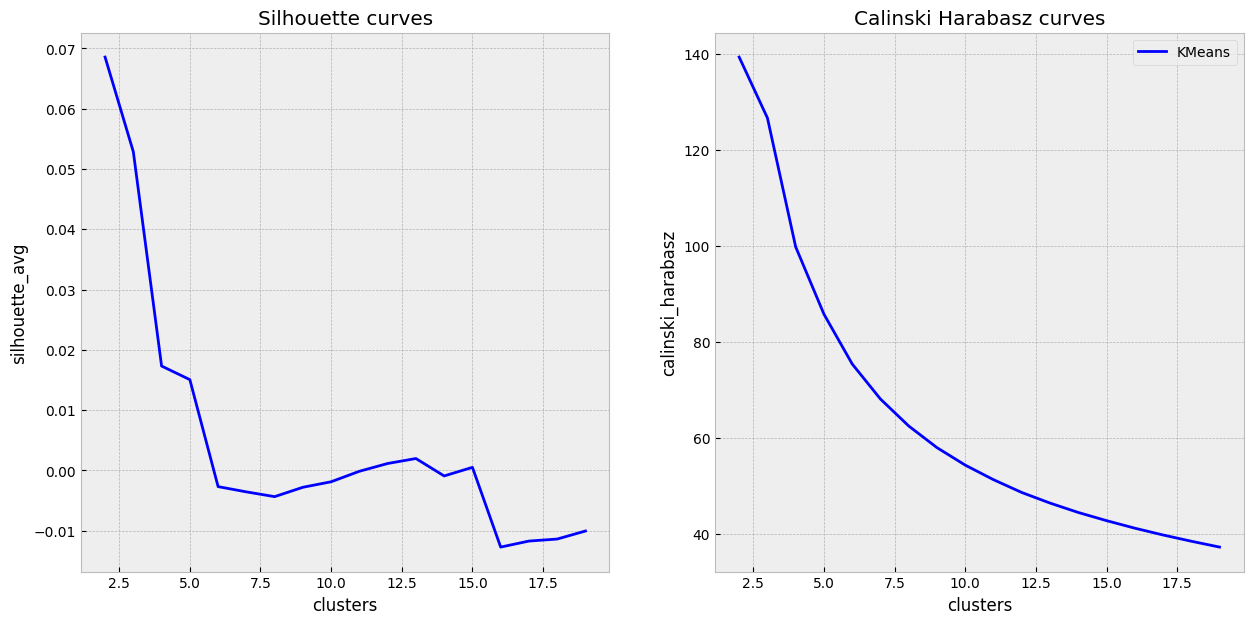

In [ ]:

a = []
X = datasetR.to_numpy(dtype='float')
for ncl in np.arange(2, int(20), 1):
 clusterer = Birch(n_clusters=int(ncl))
 with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  cluster_labels2 = clusterer.fit_predict(X)
 silhouette_avg2 = silhouette_score(X, cluster_labels2)
 calinski2 = calinski_harabasz_score(X, cluster_labels2)
 row = pd.DataFrame({"ncl": [ncl],
                     "silKMeans": [silhouette_avg2], "c_hKMeans": [calinski2],
                     })
 a.append(row)

scores = pd.concat(a, ignore_index=True)
plt.style.use('bmh')
fig, [ax_sil, ax_ch] = plt.subplots(1,2,figsize=(15,7))
ax_sil.plot(scores["ncl"], scores["silKMeans"], 'b-')
ax_ch.plot(scores["ncl"], scores["c_hKMeans"], 'b-', label='KMeans')
ax_sil.set_title("Silhouette curves")
ax_ch.set_title("Calinski Harabasz curves")
ax_sil.set_xlabel('clusters')
ax_sil.set_ylabel('silhouette_avg')
ax_ch.set_xlabel('clusters')
ax_ch.set_ylabel('calinski_harabasz')
ax_ch.legend(loc="upper right")
plt.show()

Pick a number of clusters and run the Birch algorithm

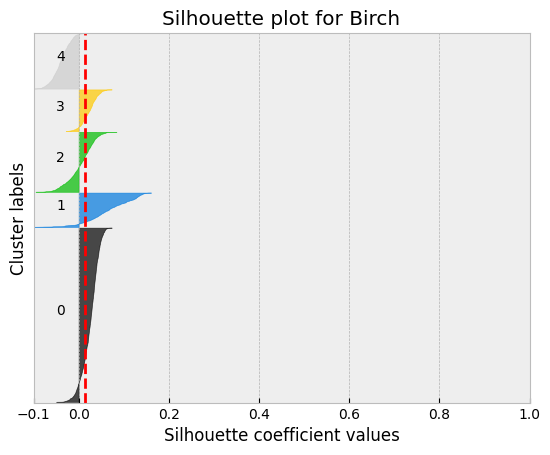

In [ ]:
ncl_KMeans = 5

with warnings.catch_warnings():
 warnings.simplefilter("ignore")
 clusterer2 = Birch(n_clusters=int(ncl_KMeans))
 cluster_labels2 = clusterer2.fit_predict(X)
n_clusters2 = max(cluster_labels2)
silhouette_avg2 = silhouette_score(X, cluster_labels2)
sample_silhouette_values2 = silhouette_samples(X, cluster_labels2)

finalDF = datasetR.copy()
finalDF["cluster"] = cluster_labels2
finalDF["silhouette"] = sample_silhouette_values2

fig, ax2 = plt.subplots()

ax2.set_xlim([-0.1, 1])
ax2.set_ylim([0, len(X) + (n_clusters2 + 1) * 10])
y_lower = 10
for i in range(min(cluster_labels2),max(cluster_labels2)+1):
 ith_cluster_silhouette_values = sample_silhouette_values2[cluster_labels2 == i]
 ith_cluster_silhouette_values.sort()
 size_cluster_i = ith_cluster_silhouette_values.shape[0]
 y_upper = y_lower + size_cluster_i
 color = cm.nipy_spectral(float(i) / n_clusters2)
 ax2.fill_betweenx(
  np.arange(y_lower, y_upper),
  0,
  ith_cluster_silhouette_values,
  facecolor=color,
  edgecolor=color,
  alpha=0.7,
 )
 ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 y_lower = y_upper + 10  # 10 for the 0 samples
ax2.set_title("Silhouette plot for Birch")
ax2.set_xlabel("Silhouette coefficient values")
ax2.set_ylabel("Cluster labels")
ax2.axvline(x=silhouette_avg2, color="red", linestyle="--")
ax2.set_yticks([])  # Clear the yaxis labels / ticks
ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

We can see by selecting the top 3 news by silhouette in each category that the classification makes sense.

In [ ]:
showDF = finalDF.sort_values(['cluster','silhouette'], ascending=[False,False]).groupby('cluster').head(3)
showDF = pd.merge(showDF[['cluster','silhouette']],maindatasetF[["index",'title']], left_index=True ,right_on=["index"])
showDF

,cluster,silhouette,index,title
97971,4,0.009239,99584,Bionic legs and smart slacks: exoskeletons that could enhance us all
93636,4,0.008592,95240,Rise of the machines: who is the ‘internet of things’ good for?
97058,4,0.007605,98668,Swedish supermarkets replace sticky labels with laser marking
96017,3,0.073133,97625,UN welcomes Syria ceasefire against backdrop of deadlock and dissent
94889,3,0.066841,96496,Kurds see chance to advance their cause in ruins of Islamic State
96044,3,0.063191,97652,South Korea set to change policy on North as liberal wins election
95534,2,0.083749,97141,"Funny, messy and real: why Sharon Horgan is the most watchable woman on TV"
98367,2,0.081540,99981,Sharon Horgan: Queen of difficult women
95237,2,0.065765,96844,Sarah Waters: ‘The Handmaiden turns pornography into a spectacle – but it’s true to my novel’
96282,1,0.160440,97890,Premier League and EFL Cup: eight talking points from the weekend’s action
